<a href="https://colab.research.google.com/github/ChiaraDropper/pclT/blob/main/ToFNet_light_010925.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#cella 0, estraggo
!unzip /content/dataset.zip -d /content/dataset

Archive:  /content/dataset.zip
   creating: /content/dataset/dataset/
   creating: /content/dataset/dataset/label_2/
  inflating: /content/dataset/dataset/label_2/000000.txt  
  inflating: /content/dataset/dataset/label_2/000001.txt  
  inflating: /content/dataset/dataset/label_2/000002.txt  
  inflating: /content/dataset/dataset/label_2/000003.txt  
  inflating: /content/dataset/dataset/label_2/000004.txt  
  inflating: /content/dataset/dataset/label_2/000005.txt  
  inflating: /content/dataset/dataset/label_2/000006.txt  
  inflating: /content/dataset/dataset/label_2/000007.txt  
  inflating: /content/dataset/dataset/label_2/000008.txt  
  inflating: /content/dataset/dataset/label_2/000009.txt  
  inflating: /content/dataset/dataset/label_2/000010.txt  
  inflating: /content/dataset/dataset/label_2/000011.txt  
  inflating: /content/dataset/dataset/label_2/000012.txt  
  inflating: /content/dataset/dataset/label_2/000013.txt  
  inflating: /content/dataset/dataset/label_2/000014.txt 

SETUP

In [3]:
# ======================================================
# STEP 1: Setup ambiente
# ======================================================
!pip install torch torchvision onnx onnxruntime filterpy open3d scikit-learn

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from filterpy.kalman import KalmanFilter
from scipy.optimize import linear_sum_assignment

# Scegli device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 128.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.5 MB/s eta 0:00:00
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=2c63ffa39304f9abf3f4bdb0c8d291a204400670bec6f8eb00f74fecd1865a06
  Stored in di

In [4]:
import random
SEED=42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False



DATASET

In [5]:
# ======================================================
# STEP 2: Dataset
# ======================================================
class ToFDataset(Dataset):
    def __init__(self, root="dataset", num_points=1024, max_persons=2, augment=False):
        self.velo_dir = os.path.join(root, "velodyne")
        self.label_dir = os.path.join(root, "label_2")
        self.files = sorted(os.listdir(self.velo_dir))
        self.num_points = num_points
        self.max_persons = max_persons
        self.augment = augment

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        pts = np.fromfile(os.path.join(self.velo_dir, fname), dtype=np.float32).reshape(-1,4)[:, :3]

        # Downsample a num_points
        choice = np.random.choice(pts.shape[0], self.num_points, replace=True if pts.shape[0] < self.num_points else False)
        pts = pts[choice, :]

        # Augment semplice
        if self.augment:
            pts += np.random.normal(0, 0.01, size=pts.shape)

        # Labels
        persons = []
        label_path = os.path.join(self.label_dir, fname.replace(".bin",".txt"))
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    if line.strip():
                        _, x, y, z = line.strip().split()
                        persons.append([float(x)/1000, float(y)/1000, float(z)/1000]) # mm→m

        num_persons = min(len(persons), self.max_persons)
        centroids = np.zeros((self.max_persons, 3), dtype=np.float32)
        if num_persons > 0:
            centroids[:num_persons] = np.array(persons[:self.max_persons])

        return torch.from_numpy(pts).float(), torch.tensor(num_persons), torch.from_numpy(centroids).float()


MODELLO

In [6]:
# ======================================================
# STEP 3: Modello ToFNet_light
# ======================================================
class ToFNetLight(nn.Module):
    def __init__(self, max_persons=2):
        super(ToFNetLight, self).__init__()
        self.max_persons = max_persons
        self.mlp1 = nn.Linear(3, 64)
        self.mlp2 = nn.Linear(64, 128)
        self.mlp3 = nn.Linear(128, 256)
        self.fc_class = nn.Linear(256, max_persons+1)  # 0,1,2 persone
        self.fc_reg   = nn.Linear(256, max_persons*3)  # centroidi

    def forward(self, x):
        x = F.relu(self.mlp1(x))
        x = F.relu(self.mlp2(x))
        x = F.relu(self.mlp3(x))
        x = torch.max(x, dim=1)[0]   # global max pooling
        class_logits = self.fc_class(x)
        reg_coords   = self.fc_reg(x).view(-1, self.max_persons, 3)
        return class_logits, reg_coords


TRAINING

In [7]:
# ======================================================
# STEP 4: Training con Early Stopping
# ======================================================
def train_model(model, train_loader, val_loader, optimizer, criterion_class, criterion_reg,
                device, max_epochs=100, patience=10, min_delta=0.01):

    best_val_loss = float("inf")
    patience_counter = 0
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(max_epochs):
        # TRAIN
        model.train()
        total_loss = 0
        for pts, n_persons, centroids in train_loader:
            pts, n_persons, centroids = pts.to(device), n_persons.to(device), centroids.to(device)
            optimizer.zero_grad()
            class_logits, reg_coords = model(pts)
            loss_class = criterion_class(class_logits, n_persons)
            mask = (n_persons > 0)
            loss_reg = criterion_reg(reg_coords[mask], centroids[mask]) if mask.any() else 0
            loss = loss_class + 0.1 * loss_reg
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss = total_loss / len(train_loader)

        # VAL
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for pts, n_persons, centroids in val_loader:
                pts, n_persons, centroids = pts.to(device), n_persons.to(device), centroids.to(device)
                class_logits, reg_coords = model(pts)
                loss_class = criterion_class(class_logits, n_persons)
                mask = (n_persons > 0)
                loss_reg = criterion_reg(reg_coords[mask], centroids[mask]) if mask.any() else 0
                loss = loss_class + 0.1 * loss_reg
                val_loss += loss.item()
        val_loss /= len(val_loader)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        print(f"Epoch {epoch}: Train {train_loss:.4f} | Val {val_loss:.4f}")

        # Early stopping
        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early stopping")
                break

    return history


VALUTAZIONE

In [8]:
# ======================================================
# STEP 5: Test finale
# ======================================================
def test_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    bad_cases = []

    with torch.no_grad():
        for idx, (pts, n_persons, centroids) in enumerate(test_loader):
            pts, n_persons, centroids = pts.to(device), n_persons.to(device), centroids.to(device)
            class_logits, reg_coords = model(pts)
            pred_class = torch.argmax(class_logits, dim=1).item()
            y_true.append(n_persons.item())
            y_pred.append(pred_class)

            if pred_class != n_persons.item():
                bad_cases.append((idx, f"GT={n_persons.item()}, Pred={pred_class}"))

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    prec = precision_score(y_true, y_pred, average="macro")
    rec  = recall_score(y_true, y_pred, average="macro")

    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("Esempi bad cases:", bad_cases[:5])
    return y_true, y_pred, bad_cases


TRACKING

In [9]:
# ======================================================
# STEP 6: Tracking + Conteggio
# ======================================================
def create_kalman():
    kf = KalmanFilter(dim_x=6, dim_z=3)
    dt = 1.0
    kf.F = np.array([[1,0,0,dt,0,0],
                     [0,1,0,0,dt,0],
                     [0,0,1,0,0,dt],
                     [0,0,0,1,0,0],
                     [0,0,0,0,1,0],
                     [0,0,0,0,0,1]], dtype=float)
    kf.H = np.array([[1,0,0,0,0,0],
                     [0,1,0,0,0,0],
                     [0,0,1,0,0,0]], dtype=float)
    # Incertezze ragionevoli in metri
    kf.P = np.diag([0.5, 0.5, 0.5, 1.0, 1.0, 1.0])   # stato iniziale abbastanza incerto
    kf.R = np.diag([0.05, 0.05, 0.05])              # rumore misura ~7 cm
    kf.Q = np.eye(6) * 0.01                          # rumore processo
    return kf
class MultiPersonTracker:
    def __init__(self, max_age=8, dist_threshold=0.7):
        self.tracks = {}  # tid -> {'kf': KalmanFilter, 'age': int}
        self.next_id = 0
        self.max_age = max_age
        self.dist_threshold = dist_threshold

    def update(self, detections):
        # detections: list/array di (x,y,z) in metri
        detections = [np.asarray(d).reshape(3,) for d in detections]

        # 1) Predict e invecchia tutti i track
        preds = []
        tids = list(self.tracks.keys())
        for tid in tids:
            trk = self.tracks[tid]
            trk['kf'].predict()
            trk['age'] += 1  # reset a 0 quando viene associato
            preds.append((tid, trk['kf'].x[:3].reshape(-1)))

        matched_tids = set()
        unmatched_tids = set(tids)
        unmatched_dets = set(range(len(detections)))

        # 2) Hungarian con GATING (costi enormi se > soglia)
        if len(preds) > 0 and len(detections) > 0:
            cost = np.full((len(preds), len(detections)), 1e6, dtype=float)
            for i, (tid, p) in enumerate(preds):
                for j, d in enumerate(detections):
                    dist = np.linalg.norm(p - d)
                    if dist <= self.dist_threshold:
                        cost[i, j] = dist
            row_ind, col_ind = linear_sum_assignment(cost)
            for r, c in zip(row_ind, col_ind):
                if cost[r, c] < 1e6:  # entro gating
                    tid = preds[r][0]
                    self.tracks[tid]['kf'].update(detections[c])
                    self.tracks[tid]['age'] = 0
                    matched_tids.add(tid)
                    if tid in unmatched_tids: unmatched_tids.remove(tid)
                    if c in unmatched_dets: unmatched_dets.remove(c)

        # 3) Nuove tracce per le detection non assegnate
        for j in unmatched_dets:
            kf = create_kalman()
            kf.x[:3] = detections[j].reshape(3,1)
            self.tracks[self.next_id] = {"kf": kf, "age": 0}
            matched_tids.add(self.next_id)
            self.next_id += 1

        # 4) Cancella tracce vecchie (mai aggiornate)
        to_del = [tid for tid, trk in self.tracks.items() if trk['age'] > self.max_age]
        for tid in to_del:
            del self.tracks[tid]

        # 5) Ritorna tutte le tracce attive (posizione predetta/aggiornata)
        return {tid: self.tracks[tid]['kf'].x[:3].reshape(-1) for tid in self.tracks}

from collections import deque

from collections import deque

class LineCounter:
    """
    Conteggio robusto con deadzone, smoothing e anti-doppio-conteggio + LOG eventi.
    """
    def __init__(self, line_position=0.0, axis=0, deadzone=0.03,
                 min_cross_travel=0.15, cooldown_frames=12,
                 smooth_window=5, positive_is_out=True):
        self.line = line_position
        self.axis = axis
        self.deadzone = deadzone
        self.min_cross = min_cross_travel
        self.cooldown_frames = cooldown_frames
        self.smooth_window = smooth_window
        self.positive_is_out = positive_is_out

        self.in_count = 0
        self.out_count = 0

        self.hist = {}   # tid -> deque di coordinate
        self.state = {}  # tid -> {'armed_side','armed_pos','cooldown'}
        self.events = [] # lista eventi: dict(frame, track_id, direction, value, axis, line)

    def _side(self, v):
        if v <= self.line - self.deadzone: return 'neg'
        if v >= self.line + self.deadzone: return 'pos'
        return 'mid'

    def reset(self):
        self.in_count = 0
        self.out_count = 0
        self.hist.clear()
        self.state.clear()
        self.events.clear()

    def update(self, tracks, frame_id=None):
        # scala cooldown
        for tid, st in list(self.state.items()):
            if st['cooldown'] > 0:
                st['cooldown'] -= 1

        for tid, pos in tracks.items():
            coord = float(pos[self.axis])
            dq = self.hist.setdefault(tid, deque(maxlen=self.smooth_window))
            dq.append(coord)
            s_coord = float(np.median(dq))

            st = self.state.get(tid, {'armed_side': None, 'armed_pos': None, 'cooldown': 0})
            side = self._side(s_coord)

            # arming
            if st['armed_side'] is None:
                if side in ('neg','pos'):
                    st['armed_side'] = side
                    st['armed_pos']  = s_coord

            else:
                # crossing
                if side in ('neg','pos') and side != st['armed_side']:
                    travel = abs(s_coord - st['armed_pos'])
                    if travel >= self.min_cross and st['cooldown'] == 0:
                        if side == 'pos' and st['armed_side'] == 'neg':
                            # neg -> pos
                            direction = 'OUT' if self.positive_is_out else 'IN'
                        elif side == 'neg' and st['armed_side'] == 'pos':
                            direction = 'IN' if self.positive_is_out else 'OUT'
                        else:
                            direction = None

                        if direction is not None:
                            if direction == 'IN':  self.in_count  += 1
                            if direction == 'OUT': self.out_count += 1
                            self.events.append({
                                'frame': frame_id,
                                'track_id': tid,
                                'direction': direction,
                                'value': s_coord,
                                'axis': self.axis,
                                'line': self.line
                            })
                            print(f"[CROSS] frame={frame_id} tid={tid} {st['armed_side']}-> {side} "f"travel={travel:.3f} line={self.line:.3f} dir={direction}")

                            st['cooldown']  = self.cooldown_frames
                            st['armed_side'] = side
                            st['armed_pos']  = s_coord

                elif side == st['armed_side']:
                    st['armed_pos'] = s_coord  # aggiorna riferimento

            self.state[tid] = st

        return self.in_count, self.out_count


CARICAMENTO DATASET

In [10]:
# ======================================================
# STEP 7: Caricamento dataset
# ======================================================
root = "dataset/dataset"   # cartella dove hai velodyne/ e label_2/
full_dataset = ToFDataset(root=root, augment=True)

# Divisione train/val/test (70/15/15%)
n_total = len(full_dataset)
n_train = int(0.7 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val

import random
SEED=42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

# split deterministico
g = torch.Generator().manual_seed(SEED)
train_set, val_set, test_set = random_split(full_dataset, [n_train, n_val, n_test], generator=g)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=1, shuffle=False)

print("Train:", len(train_set), "Val:", len(val_set), "Test:", len(test_set))


Train: 1169 Val: 250 Test: 252


MODELLO E TRAINING

In [11]:
# ======================================================
# STEP 8: Creazione modello e training
# ======================================================
model = ToFNetLight(max_persons=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion_class = nn.CrossEntropyLoss()
criterion_reg   = nn.MSELoss()

history = train_model(model, train_loader, val_loader,
                      optimizer, criterion_class, criterion_reg,
                      device, max_epochs=50, patience=5)

# Carica best pesi
model.load_state_dict(torch.load("best_model.pth"))

# ===== Export ONNX =====
model.eval()
dummy = torch.randn(1, 1024, 3).to(device)

torch.onnx.export(
    model, dummy, "tofnet_light.onnx",
    input_names=["pts"],
    output_names=["class_logits", "reg_coords"],
    dynamic_axes={"pts": {1: "num_points"}},  # consenti N variabile
    opset_version=17
)
print("✅ Esportato ONNX: tofnet_light.onnx")



Epoch 0: Train 27.1238 | Val 2.0086
Epoch 1: Train 1.8242 | Val 1.2847
Epoch 2: Train 1.5552 | Val 1.0826
Epoch 3: Train 2.0075 | Val 2.1543
Epoch 4: Train 2.8708 | Val 1.9568
Epoch 5: Train 1.2006 | Val 0.7157
Epoch 6: Train 1.0176 | Val 2.2559
Epoch 7: Train 0.7527 | Val 0.4850
Epoch 8: Train 0.6809 | Val 0.5876
Epoch 9: Train 1.2023 | Val 0.4224
Epoch 10: Train 0.4789 | Val 0.4639
Epoch 11: Train 0.5266 | Val 4.5501
Epoch 12: Train 1.2660 | Val 2.1302
Epoch 13: Train 0.7464 | Val 0.3593
Epoch 14: Train 0.4321 | Val 1.0498
Epoch 15: Train 0.4199 | Val 0.5490
Epoch 16: Train 0.3606 | Val 0.3004
Epoch 17: Train 0.4526 | Val 0.7647
Epoch 18: Train 0.5383 | Val 0.2729
Epoch 19: Train 0.4523 | Val 0.2481
Epoch 20: Train 0.3503 | Val 0.2643
Epoch 21: Train 0.4235 | Val 0.4111
Epoch 22: Train 0.3780 | Val 0.2793
Epoch 23: Train 0.3413 | Val 0.2079
Epoch 24: Train 0.4273 | Val 1.4829
Epoch 25: Train 0.8229 | Val 0.4038
Epoch 26: Train 0.3993 | Val 0.2506
Epoch 27: Train 0.3255 | Val 0.2187
E

/tmp/ipython-input-152169274.py:20: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


In [40]:
def load_bin_points_det(dataset, filename, N=1024):
    bin_path = os.path.join(dataset.velo_dir, f"{filename:06d}.bin")
    pts = np.fromfile(bin_path, dtype=np.float32).reshape(-1,4)[:, :3]
    rng = np.random.default_rng(seed=int(filename))  # SEMPRE uguale per lo stesso frame
    choice = rng.choice(len(pts), N, replace=(len(pts) < N))
    pts = pts[choice, :]
    return torch.from_numpy(pts).float()


In [41]:
import onnxruntime as ort

class ORTWrapper(nn.Module):
    """
    Se onnx_path è dato, usa ORT; altrimenti inoltra a torch_model.
    Restituisce (class_logits, reg_coords) come tensori torch, così il resto del codice non cambia.
    """
    def __init__(self, torch_model=None, onnx_path=None, device="cpu", unit_scale_pts=1.0):
        super().__init__()
        self.torch_model = torch_model
        self.device = device
        self.unit_scale_pts = float(unit_scale_pts)
        if onnx_path is not None:
            self.sess = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])
        else:
            self.sess = None

    def forward(self, pts):
        # pts: torch tensor (1,N,3) in METRI (coerenti col training)
        if self.sess is None:
            return self.torch_model(pts)
        pts_np = (pts.detach().cpu().numpy().astype(np.float32)) * self.unit_scale_pts
        out_cls, out_reg = self.sess.run(["class_logits", "reg_coords"], {"pts": pts_np})
        # ritorna torch tensors sul device così il codice a valle è invariato
        return torch.from_numpy(out_cls).to(self.device), torch.from_numpy(out_reg).to(self.device)

# Usa ONNX nella parte "inference/test" senza toccare il resto:
USE_ONNX = False  # <-- metti False se vuoi tornare a PyTorch
if USE_ONNX:
    model = ORTWrapper(torch_model=None, onnx_path="tofnet_light.onnx", device=device)
else:
    model = ORTWrapper(torch_model=model, onnx_path=None, device=device)
print("🔁 Backend:", "ONNX Runtime" if USE_ONNX else "PyTorch")


from onnxruntime.quantization import quantize_dynamic, QuantType
quantize_dynamic("tofnet_light.onnx", "tofnet_light_int8.onnx", weight_type=QuantType.QInt8)
print("✅ Quantizzato: tofnet_light_int8.onnx")
# Se vuoi usare il quantizzato:
# model = ORTWrapper(torch_model=None, onnx_path="tofnet_light_int8.onnx", device=device)



🔁 Backend: PyTorch
✅ Quantizzato: tofnet_light_int8.onnx


In [42]:
def load_bin_points(dataset, filename, N=1024):
    bin_path = os.path.join(dataset.velo_dir, f"{filename:06d}.bin")
    pts = np.fromfile(bin_path, dtype=np.float32).reshape(-1,4)[:, :3]
    choice = np.random.choice(len(pts), N, replace=(len(pts) < N))  # <- NO seed fisso
    pts = pts[choice, :]
    return torch.from_numpy(pts).float()


In [43]:
def parity_test(frames=[555, 570, 600]):
    # Build due backend
    torch_backend = ORTWrapper(torch_model=ToFNetLight(max_persons=2).to(device), onnx_path=None, device=device)
    torch_backend.torch_model.load_state_dict(torch.load("best_model.pth"))
    torch_backend.torch_model.eval()

    onnx_backend  = ORTWrapper(torch_model=None, onnx_path="tofnet_light.onnx", device=device)

    for f in frames:
        pts = load_bin_points_det(full_dataset, f).unsqueeze(0).to(device)

        with torch.no_grad():
            cls_t, reg_t = torch_backend(pts)
        cls_o, reg_o = onnx_backend(pts)

        pt_cls = int(torch.argmax(cls_t, dim=1).item())
        on_cls = int(torch.argmax(cls_o, dim=1).item())
        diff = float(np.linalg.norm(reg_t.detach().cpu().numpy() - reg_o.detach().cpu().numpy()))

        print(f"[Frame {f}] class PT={pt_cls} ONNX={on_cls} | L2(reg) diff={diff:.6f}")

parity_test([555, 563, 574, 591, 620])


[Frame 555] class PT=1 ONNX=1 | L2(reg) diff=0.000006
[Frame 563] class PT=1 ONNX=1 | L2(reg) diff=0.000003
[Frame 574] class PT=1 ONNX=1 | L2(reg) diff=0.000002
[Frame 591] class PT=1 ONNX=1 | L2(reg) diff=0.000007
[Frame 620] class PT=1 ONNX=1 | L2(reg) diff=0.000008


VALUTAZIONE FINALE

Accuracy: 0.9246031746031746
Precision: 0.9435830211088255
Recall: 0.8948461354901274
Esempi bad cases: [(6, 'GT=2, Pred=1'), (13, 'GT=2, Pred=1'), (52, 'GT=2, Pred=1'), (53, 'GT=1, Pred=2'), (61, 'GT=2, Pred=1')]


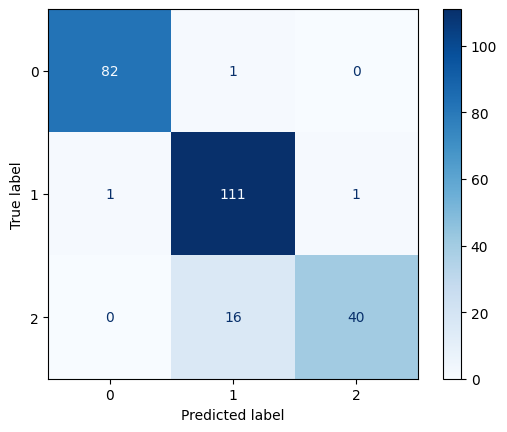

In [44]:
# ======================================================
# STEP 9: Test finale
# ======================================================
y_true, y_pred, bad_cases = test_model(model, test_loader, device)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])
disp.plot(cmap="Blues")
plt.show()


DEBUG

In [45]:
# ======================================================
# STEP 10: Debug su range noti
# ======================================================
def debug_range(model, dataset, start, end):
    model.eval()
    for idx in range(start, end+1):
        pts, n_persons, centroids = dataset[idx]
        pts, n_persons, centroids = pts.unsqueeze(0).to(device), n_persons.to(device), centroids.to(device)
        with torch.no_grad():
            class_logits, reg_coords = model(pts)
            pred_class = torch.argmax(class_logits, dim=1).item()
            pred_centroids = reg_coords.squeeze(0).cpu().numpy()
        print(f"Frame {idx}: GT={n_persons.item()} | Pred={pred_class} | Centroidi pred={pred_centroids}")

# Debug intervalli
debug_range(model, full_dataset, 555, 590)  # uscita
debug_range(model, full_dataset, 591, 620)  # entrata


Frame 555: GT=1 | Pred=1 | Centroidi pred=[[ 0.44117734  0.3501694  -0.55094844]
 [-0.38010785 -1.5968683   0.3995846 ]]
Frame 556: GT=1 | Pred=1 | Centroidi pred=[[-0.37063792  0.20895533 -0.68644756]
 [-0.45140502  0.31985635  0.19909412]]
Frame 557: GT=1 | Pred=1 | Centroidi pred=[[-0.01184501  0.97992206 -0.12770098]
 [-0.22817704 -0.2394678   0.4042483 ]]
Frame 558: GT=1 | Pred=1 | Centroidi pred=[[-0.22002378  0.25379512 -0.0903787 ]
 [-0.86473703 -0.32309258 -0.18039769]]
Frame 559: GT=1 | Pred=1 | Centroidi pred=[[ 1.2566534   1.8454908  -0.7533744 ]
 [ 0.02815297 -0.702437   -0.10500497]]
Frame 560: GT=1 | Pred=1 | Centroidi pred=[[ 0.11489711  0.39312223 -0.6808333 ]
 [-0.8876023  -0.09513664 -0.6751792 ]]
Frame 561: GT=1 | Pred=1 | Centroidi pred=[[-0.3071697   0.29037443  0.44244605]
 [-0.4436464  -0.32759082 -0.362261  ]]
Frame 562: GT=1 | Pred=1 | Centroidi pred=[[-0.08167972  0.6083119  -0.07310003]
 [-0.35937545 -0.46916598 -0.41447705]]
Frame 563: GT=1 | Pred=1 | Centr

INFERENZA SUI FRAME

In [46]:

def load_bin_points(dataset, filename, N=1024):
    bin_path = os.path.join(dataset.velo_dir, f"{filename:06d}.bin")
    pts = np.fromfile(bin_path, dtype=np.float32).reshape(-1,4)[:, :3]
    choice = np.random.choice(len(pts), N, replace=(len(pts) < N))  # <- NO seed fisso
    pts = pts[choice, :]
    return torch.from_numpy(pts).float()


def pc_centroid_m(pts_tensor):
    """
    Baricentro geometrico in METRI.
    Se la point cloud è in mm (valori ~centinaia), converto -> metri.
    """
    if pts_tensor.ndim == 3:
        pts = pts_tensor[0].detach().cpu().numpy()
    else:
        pts = pts_tensor.detach().cpu().numpy()

    c = np.mean(pts, axis=0).astype(np.float32)  # baricentro nelle unità natie
    # Heuristica robusta: se i numeri sono grandi, sono mm -> divido per 1000
    # (usa anche la scala dei punti per evitare falsi positivi)
    if np.max(np.abs(c)) > 10 or np.percentile(np.abs(pts[:, 0]), 95) > 10:
        c = c / 1000.0
    return c

def pick_detection_in_meters(class_logits, reg_coords, pts_tensor):
    """
    Ritorna (K,3) in METRI da passare al tracker.
    - n==1: baricentro geometrico (convertito a metri se necessario)
    - n==2: i 2 centroidi regressi (già in metri, perché le label erano mm->m)
    """
    n = int(torch.argmax(class_logits, dim=1).item())
    if n <= 0:
        return np.empty((0,3), dtype=float)
    if n == 1:
        return np.array([pc_centroid_m(pts_tensor)], dtype=float)
    # n == 2 -> già metri
    return reg_coords.squeeze(0).detach().cpu().numpy()[:2].astype(float)


def calibrate_for_axis(model, dataset, axis=0, start_f=555, end_f=580):
    """
    Calibra la linea e la direzione su [start_f, end_f] come nel vecchio codice:
    - se 1 persona: usa la sola detection
    - se 2 persone: prende quella con |y| più grande (più "frontale")
    """
    coords = []
    model.eval()
    for f in range(start_f, end_f+1):
        pts = load_bin_points_det(dataset, f).unsqueeze(0).to(device)
        with torch.no_grad():
            cl, rc = model(pts)
        dets = pick_detection_in_meters(cl, rc, pts)
        if dets.shape[0] == 0:
            continue
        c = dets[0] if dets.shape[0] == 1 else dets[np.argmax(np.abs(dets[:,1]))]
        coords.append(float(c[axis]))

    if len(coords) < 3:
        return 0.0, True

    coords = np.array(coords, dtype=float)
    p20, p80 = np.percentile(coords, [20, 80])
    line_pos = 0.5 * (p20 + p80)

    k = max(1, len(coords)//5)
    start_med = np.median(coords[:k])
    end_med   = np.median(coords[-k:])
    positive_is_out = (end_med > start_med)
    return float(line_pos), bool(positive_is_out)


axis = 0  # X
line_pos, pos_is_out = calibrate_for_axis(model, full_dataset, axis=axis, start_f=555, end_f=580)
print(f"[Calib X] axis={axis} (x), line={line_pos:.3f} m, positive_is_out={pos_is_out}")


[Calib X] axis=0 (x), line=-0.197 m, positive_is_out=True


In [47]:
# Calibrazione su X
axis = 0
line_pos, pos_is_out = calibrate_for_axis(model, full_dataset, axis=axis, start_f=555, end_f=580)
#print(f"[Calib X] axis={axis} (x), line={line_pos:.3f} m, positive_is_out={pos_is_out}")

# Deadzone adattiva ma con bound (2cm–6cm)
# (Puoi anche fissarla a 0.03 se preferisci)
vals_x = []
model.eval()
for f in range(555, 581):
    pts = load_bin_points_det(full_dataset, f).unsqueeze(0).to(device)
    with torch.no_grad():
        class_logits, reg_coords = model(pts)
    dets = pick_detection_in_meters(class_logits, reg_coords, pts)
    if dets.shape[0] == 0: continue
    c = dets[0] if dets.shape[0]==1 else dets[np.argmax(np.abs(dets[:,1]))]
    vals_x.append(float(c[axis]))
span_x = (max(vals_x)-min(vals_x)) if len(vals_x)>0 else 0.2
deadzone = min(0.06, max(0.02, 0.20*span_x))

#print(f"[Run] line={line_pos:.3f}, deadzone={deadzone:.3f}, pos_is_out={pos_is_out}")

tracker  = MultiPersonTracker(max_age=6, dist_threshold=0.7)
counter  = LineCounter(line_position=line_pos, axis=axis,
                       deadzone=deadzone, min_cross_travel=0.20,
                       cooldown_frames=12, smooth_window=5,
                       positive_is_out=pos_is_out)

model.eval()
for f in range(631, 650):
    pts = load_bin_points_det(full_dataset, f).unsqueeze(0).to(device)
    with torch.no_grad():
        class_logits, reg_coords = model(pts)
    dets = pick_detection_in_meters(class_logits, reg_coords, pts)
    tracks = tracker.update(dets)
    inc, outc = counter.update(tracks)

    main_val = None
    if len(tracks) > 0:
        tid0 = sorted(tracks.keys())[0]
        main_val = float(tracks[tid0][axis])
    #print(f"Frame {f}: n={torch.argmax(class_logits,1).item()}, x={None if main_val is None else round(main_val,3)}, IN={inc}, OUT={outc}")

def run_range_fixed(model, dataset, start_f, end_f, CAL,
                    deadzone=None, min_cross=0.20, cooldown=12, smooth_w=5):
    """
    Esegue tracking+conteggio in [start_f, end_f] usando una calibrazione *fissa*:
      CAL = {"axis": 0/1, "line": float, "pos_out": bool}
    """
    axis = CAL["axis"]
    line = CAL["line"]
    pos_is_out = CAL["pos_out"]

    # Deadzone adattiva se non specificata (bounded 2–6 cm)
    vals = []
    model.eval()
    for f in range(start_f, end_f+1):
        pts = load_bin_points_det(dataset, f).unsqueeze(0).to(device)
        with torch.no_grad():
            cl, rc = model(pts)
        dets = pick_detection_in_meters(cl, rc, pts)
        if dets.shape[0] == 0:
            continue
        c = dets[0] if dets.shape[0]==1 else dets[np.argmax(np.abs(dets[:,1]))]
        vals.append(float(c[axis]))
    span = (max(vals)-min(vals)) if len(vals)>0 else 0.2
    dz = deadzone if deadzone is not None else min(0.06, max(0.02, 0.20*span))

    print(f"[RUN FIXED] axis={axis} line={line:.3f} deadzone={dz:.3f} dir={'OUT=+' if pos_is_out else 'OUT=-'}")

    tracker  = MultiPersonTracker(max_age=6, dist_threshold=0.7)
    counter  = LineCounter(line_position=line, axis=axis,
                           deadzone=dz, min_cross_travel=min_cross,
                           cooldown_frames=cooldown, smooth_window=smooth_w,
                           positive_is_out=pos_is_out)

    # Diagnostica: mediana inizio/fine sull'asse fisso (utile per capire il verso)
    if len(vals) >= 5:
        k = max(1, len(vals)//5)
        start_med = float(np.median(vals[:k]))
        end_med   = float(np.median(vals[-k:]))
        print(f"[DIR CHECK] start_med={start_med:.3f}  end_med={end_med:.3f}  delta={end_med-start_med:+.3f}")

    for f in range(start_f, end_f+1):
        pts = load_bin_points_det(dataset, f).unsqueeze(0).to(device)
        with torch.no_grad():
            cl, rc = model(pts)
        dets = pick_detection_in_meters(cl, rc, pts)
        tracks = tracker.update(dets)
        inc, outc = counter.update(tracks)

        main_val = None
        if len(tracks) > 0:
            tid0 = sorted(tracks.keys())[0]
            main_val = float(tracks[tid0][axis])
        print(f"Frame {f}: n={torch.argmax(cl,1).item()}, "
              f"{'x' if axis==0 else 'y'}={None if main_val is None else round(main_val,3)}, IN={inc}, OUT={outc}")

    print(f"\n🔹 Conteggio finale (range {start_f}–{end_f})")
    print("Entrate:", counter.in_count)
    print("Uscite:",  counter.out_count)
    return counter.in_count, counter.out_count


# Calibrazione globale (come fai già)
axis = 0
glob_line, glob_pos_is_out = calibrate_for_axis(model, full_dataset, axis=axis, start_f=555, end_f=580)
CAL = {"axis": axis, "line": float(glob_line), "pos_out": bool(glob_pos_is_out)}
# Se vuoi forzare il verso sapendo che 555–580 è OUT lungo +X:
CAL["pos_out"] = True

# Soglie che ti funzionavano:
DZ = 0.03   # 3 cm
MCT = 0.10  # 10–12 cm va bene; inizia con 10 cm per sbloccare i cross
CD = 8      # cooldown più snello
SMOOTH = 3  # smoothing moderato
run_range_fixed(model, full_dataset, 555, 580, CAL, deadzone=DZ, min_cross=MCT, cooldown=CD, smooth_w=SMOOTH)
run_range_fixed(model, full_dataset, 591, 620, CAL, deadzone=DZ, min_cross=MCT, cooldown=CD, smooth_w=SMOOTH)
run_range_fixed(model, full_dataset, 631, 650, CAL, deadzone=DZ, min_cross=MCT, cooldown=CD, smooth_w=SMOOTH)



[CROSS] frame=None tid=0 neg-> pos travel=0.200 line=-0.197 dir=OUT
[RUN FIXED] axis=0 line=-0.197 deadzone=0.030 dir=OUT=+
[DIR CHECK] start_med=-0.507  end_med=0.092  delta=+0.599
Frame 555: n=1, x=-0.507, IN=0, OUT=0
Frame 556: n=1, x=-0.526, IN=0, OUT=0
Frame 557: n=1, x=-0.526, IN=0, OUT=0
Frame 558: n=1, x=-0.508, IN=0, OUT=0
Frame 559: n=1, x=-0.473, IN=0, OUT=0
Frame 560: n=1, x=-0.432, IN=0, OUT=0
Frame 561: n=1, x=-0.38, IN=0, OUT=0
Frame 562: n=1, x=-0.331, IN=0, OUT=0
Frame 563: n=1, x=-0.302, IN=0, OUT=0
Frame 564: n=1, x=-0.273, IN=0, OUT=0
Frame 565: n=1, x=-0.246, IN=0, OUT=0
Frame 566: n=1, x=-0.217, IN=0, OUT=0
Frame 567: n=1, x=-0.169, IN=0, OUT=0
Frame 568: n=1, x=-0.142, IN=0, OUT=0
[CROSS] frame=None tid=0 neg-> pos travel=0.104 line=-0.197 dir=OUT
Frame 569: n=1, x=-0.117, IN=0, OUT=1
Frame 570: n=1, x=-0.084, IN=0, OUT=1
Frame 571: n=1, x=-0.053, IN=0, OUT=1
Frame 572: n=1, x=-0.013, IN=0, OUT=1
Frame 573: n=1, x=0.015, IN=0, OUT=1
Frame 574: n=1, x=0.035, IN=0,

(0, 1)

In [48]:
def quick_smoke(model, dataset, CAL, ranges,
                DZ=0.03, MCT=0.10, CD=8, SMOOTH=3):
    axis = CAL["axis"]; line = CAL["line"]
    print(f"\n[CAL] axis={axis} line={line:.3f} m dir={'OUT=+' if CAL['pos_out'] else 'OUT=-'}")
    for (a,b,label) in ranges:
        # Distribuzione valori rispetto alla linea (loader deterministico)
        vals = []
        for f in range(a, b+1):
            pts = load_bin_points_det(dataset, f).unsqueeze(0).to(device)
            with torch.no_grad():
                cl, rc = model(pts)
            dets = pick_detection_in_meters(cl, rc, pts)
            if dets.shape[0] == 0:
                continue
            c = dets[0] if dets.shape[0]==1 else dets[np.argmax(np.abs(dets[:,1]))]
            vals.append(float(c[axis]))
        if len(vals) == 0:
            print(f"[{label}] nessuna detection.")
            continue
        vals = np.array(vals, dtype=float)
        neg = np.mean(vals < (line - DZ))
        mid = np.mean((vals >= (line - DZ)) & (vals <= (line + DZ)))
        pos = np.mean(vals > (line + DZ))
        print(f"[{label}] frames={len(vals)}  min={vals.min():.3f}  max={vals.max():.3f}  "
              f"line={line:.3f}  neg={neg:.2f}  mid={mid:.2f}  pos={pos:.2f}")
        # Conteggio vero e proprio (deterministico + logging)
        run_range_fixed(model, dataset, a, b, CAL,
                        deadzone=DZ, min_cross=MCT, cooldown=CD, smooth_w=SMOOTH)

# Lancia:
RANGES = [(555,580,"OUT atteso"), (591,620,"IN atteso"), (631,650,"terzo blocco")]
quick_smoke(model, full_dataset, CAL, RANGES, DZ=0.03, MCT=0.10, CD=8, SMOOTH=3)



[CAL] axis=0 line=-0.197 m dir=OUT=+
[OUT atteso] frames=26  min=-0.527  max=0.119  line=-0.197  neg=0.42  mid=0.04  pos=0.54
[RUN FIXED] axis=0 line=-0.197 deadzone=0.030 dir=OUT=+
[DIR CHECK] start_med=-0.507  end_med=0.092  delta=+0.599
Frame 555: n=1, x=-0.507, IN=0, OUT=0
Frame 556: n=1, x=-0.526, IN=0, OUT=0
Frame 557: n=1, x=-0.526, IN=0, OUT=0
Frame 558: n=1, x=-0.508, IN=0, OUT=0
Frame 559: n=1, x=-0.473, IN=0, OUT=0
Frame 560: n=1, x=-0.432, IN=0, OUT=0
Frame 561: n=1, x=-0.38, IN=0, OUT=0
Frame 562: n=1, x=-0.331, IN=0, OUT=0
Frame 563: n=1, x=-0.302, IN=0, OUT=0
Frame 564: n=1, x=-0.273, IN=0, OUT=0
Frame 565: n=1, x=-0.246, IN=0, OUT=0
Frame 566: n=1, x=-0.217, IN=0, OUT=0
Frame 567: n=1, x=-0.169, IN=0, OUT=0
Frame 568: n=1, x=-0.142, IN=0, OUT=0
[CROSS] frame=None tid=0 neg-> pos travel=0.104 line=-0.197 dir=OUT
Frame 569: n=1, x=-0.117, IN=0, OUT=1
Frame 570: n=1, x=-0.084, IN=0, OUT=1
Frame 571: n=1, x=-0.053, IN=0, OUT=1
Frame 572: n=1, x=-0.013, IN=0, OUT=1
Frame 57